# Methodology
We will perform a two-tail, two-sample t-test on the data. Using [Kaggle's UW Madison Grade's Database](https://www.kaggle.com/Madgrades/uw-madison-courses#schedules.csv).

## Question

Is a statitstically significant difference in the percentage of A's based on how many days a week a class meets.

## Hypotheses
We select an alpha value of 0.05.

Null Hypothesis: There is no significant difference in the mean percentage of A's if a class meets one day a week or 2-5 days a week. 

Alternate Hypothesis: There is a significant difference in the mean percentage of A's if a class meets one day a week or 2-5 days a week. 

Construct an ANOVA test.


In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn')
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math

np.random.seed(2019)

In [2]:
conn = psycopg2.connect("host=localhost,dbname=postgres,user=postgres")

cur = conn.cursor()

In [3]:
group_and_as = """
SELECT 
  grade.a_count
, grade.ab_count
, grade.b_count
, grade.bc_count
, grade.c_count
, grade.d_count
, grade.f_count
, sched.mon
, sched.tues
, sched.wed
, sched.thurs
, sched.fri
, sched.sat
, sched.sun
, sect.section_type
, grade.course_offering_uuid
, grade.section_number
FROM 
  sections sect
INNER JOIN 
  schedules sched 
ON 
  sched.uuid = sect.schedule_uuid
INNER JOIN 
  grade_distributions grade 
ON 
  sect.number = grade.section_number 
AND 
  sect.course_offering_uuid = grade.course_offering_uuid;
"""

In [4]:
cur.execute(group_and_as)
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]

In [5]:
df['total_count'] = (df['a_count'] + df['ab_count'] + df['b_count'] + df['bc_count'] 
                     + df['c_count'] + df['d_count'] + df['f_count'])

In [6]:
df['days_a_week'] = sum([df['mon'], df['tues'], df['wed'], df['thurs'], df['fri'], df['sat'], df['sun']])

In [7]:
df.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
0,40,5,0,0,0,0,0,False,True,False,True,False,False,False,LAB,3c59e623-7e61-343a-951a-765cb62d3304,7,45,2
1,40,1,1,0,0,0,0,False,True,False,True,False,False,False,LAB,3c59e623-7e61-343a-951a-765cb62d3304,6,42,2
2,22,16,0,0,0,0,0,False,True,False,True,False,False,False,LAB,52348693-479f-3262-b7ba-b9427aee66b8,4,38,2
3,27,3,2,0,1,0,1,True,False,True,False,False,False,False,LAB,a37b96cc-0586-3eac-b22e-97fb3db3bf05,5,34,2
4,29,1,1,0,0,0,0,False,True,False,True,False,False,False,LAB,dd3caaea-05bf-383a-afa4-52297c455208,4,31,2


In [8]:
df['days_a_week'].value_counts()

0    92413
2    48620
1    42123
3    17703
6     7556
5     5150
4     3811
7       23
Name: days_a_week, dtype: int64

In [9]:
df.sort_values(by='days_a_week', ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
170367,12,2,22,0,0,0,0,True,True,True,True,True,True,True,FLD,24a7419e-285d-3ce7-a3af-f204348bef02,82,36,7
212378,6,5,12,0,0,0,0,True,True,True,True,True,True,True,FLD,b6f52ef7-045b-396b-bc52-4614ed5610ba,81,23,7
115977,5,11,7,0,0,0,0,True,True,True,True,True,True,True,FLD,53abf93f-707e-3cae-afb1-fa0a69c21b4a,81,23,7
115978,8,7,11,1,0,0,0,True,True,True,True,True,True,True,FLD,6aec025e-376b-3119-b32d-8b64abfd5c10,82,27,7
115979,7,7,14,0,0,0,0,True,True,True,True,True,True,True,FLD,b6f52ef7-045b-396b-bc52-4614ed5610ba,83,28,7


In [10]:
df.sort_values(by='days_a_week', ascending=True).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
108699,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,a964f1ee-2166-3c16-9ef0-39b378ae0aad,70,0,0
87494,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,8798992a-2e85-31d8-a424-0bd39f9f7077,6,0,0
87493,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,7247c7da-feb8-3f62-a276-fbbb4819f87f,26,0,0
87492,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,f2d971c6-9f95-338d-8b29-35932bb3cad4,26,0,0
87491,0,0,0,0,0,0,0,False,False,False,False,False,False,False,IND,f2d971c6-9f95-338d-8b29-35932bb3cad4,12,0,0


We can see that there are several classes that meet zero times a week. We want to drop these. We also see that there are classes that meet 6-7 days a week which are FLD or IND, which are not representative of our problem as these are usually student paced/scheduled. As all these values are no use to our test, we will drop classes that meet 0, 6, or 7 days a week.

In [11]:
df = df[df['days_a_week'] < 6]
df = df[df['days_a_week'] > 0]
df.sort_values(by='days_a_week', ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
178999,0,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,82c699c6-7ec9-3cc5-973d-5b8d2593c1d6,1,0,5
64269,3,1,0,1,1,0,0,True,True,True,True,True,False,False,LEC,ae531ad3-4db7-33cf-b4fc-bbb8f4eccc33,2,6,5
59317,0,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,118f975c-63c6-3f32-825f-5fade423bee8,1,0,5
192017,1,2,7,0,1,0,0,True,True,True,True,True,False,False,LEC,b497d847-0964-3c7c-83db-14cdd141b6db,1,11,5
186775,0,0,0,0,0,0,0,True,True,True,True,True,False,False,FLD,a262af8f-1fab-31a7-87c2-13a0119bec33,1,0,5


There are some lectures that meet 5 days a week. So we will drop any remaining FLD or IND.

In [14]:
df = df[df['section_type'] != 'FLD']
df = df[df['section_type'] != 'IND']
df = df[df['section_type'] != 'LAB']
df = df[df['section_type'] != 'DIS']
df.sort_values(by='days_a_week', ascending=False).head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,thurs,fri,sat,sun,section_type,course_offering_uuid,section_number,total_count,days_a_week
156567,6,5,4,1,2,0,0,True,True,True,True,True,False,False,LEC,526e2c6f-8709-3156-b395-61b98eea7599,6,18,5
111587,5,4,8,0,1,0,0,True,True,True,True,True,False,False,LEC,56b805e9-6d31-3790-933a-d2f3b34d3f74,1,18,5
140221,0,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,9ee9098a-c703-314a-857e-faaa4508f5f6,1,0,5
140085,28,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,e8d930a6-e7b2-3228-9cd5-97298bf9e5a0,2,28,5
140084,28,0,0,0,0,0,0,True,True,True,True,True,False,False,LEC,e8d930a6-e7b2-3228-9cd5-97298bf9e5a0,2,28,5


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97256 entries, 7 to 217398
Data columns (total 19 columns):
a_count                 97256 non-null int64
ab_count                97256 non-null int64
b_count                 97256 non-null int64
bc_count                97256 non-null int64
c_count                 97256 non-null int64
d_count                 97256 non-null int64
f_count                 97256 non-null int64
mon                     97256 non-null bool
tues                    97256 non-null bool
wed                     97256 non-null bool
thurs                   97256 non-null bool
fri                     97256 non-null bool
sat                     97256 non-null bool
sun                     97256 non-null bool
section_type            97256 non-null object
course_offering_uuid    97256 non-null object
section_number          97256 non-null int64
total_count             97256 non-null int64
days_a_week             97256 non-null int64
dtypes: bool(7), int64(10), object(2)
me

Like with time of day, there may be some classes with zero students. We want to drop these as it is not reflective of our study.

In [16]:
df = df[df['total_count'] != 0]

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85084 entries, 7 to 217398
Data columns (total 19 columns):
a_count                 85084 non-null int64
ab_count                85084 non-null int64
b_count                 85084 non-null int64
bc_count                85084 non-null int64
c_count                 85084 non-null int64
d_count                 85084 non-null int64
f_count                 85084 non-null int64
mon                     85084 non-null bool
tues                    85084 non-null bool
wed                     85084 non-null bool
thurs                   85084 non-null bool
fri                     85084 non-null bool
sat                     85084 non-null bool
sun                     85084 non-null bool
section_type            85084 non-null object
course_offering_uuid    85084 non-null object
section_number          85084 non-null int64
total_count             85084 non-null int64
days_a_week             85084 non-null int64
dtypes: bool(7), int64(10), object(2)
me

In [18]:
df2 = df.copy()

In [19]:
df2['ratio_of_as'] = df['a_count'] / df['total_count']

In [20]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85084 entries, 7 to 217398
Data columns (total 20 columns):
a_count                 85084 non-null int64
ab_count                85084 non-null int64
b_count                 85084 non-null int64
bc_count                85084 non-null int64
c_count                 85084 non-null int64
d_count                 85084 non-null int64
f_count                 85084 non-null int64
mon                     85084 non-null bool
tues                    85084 non-null bool
wed                     85084 non-null bool
thurs                   85084 non-null bool
fri                     85084 non-null bool
sat                     85084 non-null bool
sun                     85084 non-null bool
section_type            85084 non-null object
course_offering_uuid    85084 non-null object
section_number          85084 non-null int64
total_count             85084 non-null int64
days_a_week             85084 non-null int64
ratio_of_as             85084 non-null f

In [21]:
df2.drop_duplicates(inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71381 entries, 7 to 217398
Data columns (total 20 columns):
a_count                 71381 non-null int64
ab_count                71381 non-null int64
b_count                 71381 non-null int64
bc_count                71381 non-null int64
c_count                 71381 non-null int64
d_count                 71381 non-null int64
f_count                 71381 non-null int64
mon                     71381 non-null bool
tues                    71381 non-null bool
wed                     71381 non-null bool
thurs                   71381 non-null bool
fri                     71381 non-null bool
sat                     71381 non-null bool
sun                     71381 non-null bool
section_type            71381 non-null object
course_offering_uuid    71381 non-null object
section_number          71381 non-null int64
total_count             71381 non-null int64
days_a_week             71381 non-null int64
ratio_of_as             71381 non-null f

/Users/kaylischulz/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


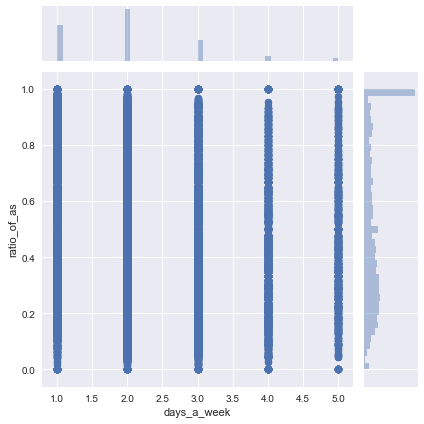

In [22]:
sns.jointplot('days_a_week', 'ratio_of_as',df2)

Create new columns for one-hot encoding for days a class meets a week in order to perform a one-way ANOVA test

In [23]:
dummied_days = pd.get_dummies(df2, columns=['days_a_week'])

In [24]:
dummied_days.head()

,a_count,ab_count,b_count,bc_count,c_count,d_count,f_count,mon,tues,wed,...,section_type,course_offering_uuid,section_number,total_count,ratio_of_as,days_a_week_1,days_a_week_2,days_a_week_3,days_a_week_4,days_a_week_5
7,81,52,94,38,55,7,8,True,False,True,...,LEC,17aba2f3-9239-30ca-8f06-6854f536ab3d,1,335,0.241791,0,0,1,0,0
8,143,54,117,19,34,7,0,True,False,True,...,LEC,f35c67c5-7006-3ee6-b311-df19f0782d47,2,374,0.382353,0,0,1,0,0
9,55,50,108,26,35,8,2,False,False,False,...,LEC,930d502c-261a-32fb-8b15-fe6571706ece,4,284,0.193662,1,0,0,0,0
10,98,55,105,37,29,16,9,True,False,True,...,LEC,a635a6a6-b8c7-3b1f-9d42-e7fd445ac1dc,3,349,0.280802,0,0,1,0,0
11,22,26,27,18,29,0,2,True,False,True,...,LEC,7f9f189d-accf-3eab-9a65-c467df1c16f3,3,124,0.177419,0,1,0,0,0


In [25]:
formula = 'ratio_of_as~C(days_a_week_1)+C(days_a_week_2)+C(days_a_week_3)+C(days_a_week_4)+C(days_a_week_5)'
lm = ols(formula, dummied_days).fit()
table = sm.stats.anova_lm(lm, type=3)
print(table)

                       df       sum_sq      mean_sq             F  \
C(days_a_week_1)      1.0  1367.433258  1367.433258  20317.602746   
C(days_a_week_2)      1.0    12.173341    12.173341    180.873991   
C(days_a_week_3)      1.0     5.998375     5.998375     89.125083   
C(days_a_week_4)      1.0     3.960900     3.960900     58.851858   
C(days_a_week_5)      1.0     0.015936     0.015936      0.236777   
Residual          71375.0  4803.743337     0.067303           NaN   

                        PR(>F)  
C(days_a_week_1)  0.000000e+00  
C(days_a_week_2)  3.506106e-41  
C(days_a_week_3)  3.813060e-21  
C(days_a_week_4)  1.721453e-14  
C(days_a_week_5)  6.265453e-01  
Residual                   NaN  


Using the Bonferroni correction we adjust our alpha to reflect 5 independent variables (0.05 / 5). Our adjusted alpha is 0.01. Since looking at two-tailed we are looking at PR(>F)'s that are less than 0.005

We are comparing to 1 day a week.

The PR(>F) values are less than alpha for 2, 3, and 4 days which means we reject the null and there is a difference in the percentage of A's given whether the class meets 2 to 1, 3 to 1, or 4 to 1 days a week. The PR(>F) for five is greater than alpha so we fail to reject the null. There is not enough information to say that there is a difference between meeting 1 day a week and 5 days a week.

The most influential of 2, 3, and 4 appears to be 2 days a week as it has the smallest PR(>F) value.

In [26]:
days_and_as = pd.DataFrame({'days_a_week': df2['days_a_week'], 'ratio_of_as': df2['ratio_of_as']})

In [27]:
one_day = days_and_as.loc[days_and_as['days_a_week'] == 1, 'ratio_of_as']
two_days = days_and_as.loc[days_and_as['days_a_week'] == 2, 'ratio_of_as']
three_days = days_and_as.loc[days_and_as['days_a_week'] == 3, 'ratio_of_as']
four_days = days_and_as.loc[days_and_as['days_a_week'] == 4, 'ratio_of_as']
five_days = days_and_as.loc[days_and_as['days_a_week'] == 5, 'ratio_of_as']

In [28]:
stats.f_oneway(one_day, two_days, three_days, four_days, five_days)

F_onewayResult(statistic=5161.702969240501, pvalue=0.0)

There is a statistical difference, but in which pairings?

In [29]:
days_pairs = []
days = [1, 2, 3, 4, 5]

In [30]:
for days1 in range(4):
    for days2  in range(days1+1,5):
        days_pairs.append((days[days1], days[days2]))

In [31]:
# Conduct t-test on each pair
for days1, days2 in days_pairs: 
    first = days_and_as.loc[days_and_as['days_a_week'] == days1, 'ratio_of_as']
    second = days_and_as.loc[days_and_as['days_a_week'] == days2, 'ratio_of_as']
    print(days1, days2)
    print(stats.ttest_ind(first, second)) 

1 2
Ttest_indResult(statistic=124.06730444574464, pvalue=0.0)
1 3
Ttest_indResult(statistic=114.51292840584209, pvalue=0.0)
1 4
Ttest_indResult(statistic=58.794794931593, pvalue=0.0)
1 5
Ttest_indResult(statistic=33.41606962852344, pvalue=2.9967139670907445e-239)
2 3
Ttest_indResult(statistic=16.588715477715603, pvalue=1.2847619665447538e-61)
2 4
Ttest_indResult(statistic=4.502073298273185, pvalue=6.751122649941066e-06)
2 5
Ttest_indResult(statistic=-5.960003315452311, pvalue=2.547577395262322e-09)
3 4
Ttest_indResult(statistic=-4.462963079268999, pvalue=8.139153894995054e-06)
3 5
Ttest_indResult(statistic=-12.782980959959122, pvalue=3.2575970151490397e-37)
4 5
Ttest_indResult(statistic=-8.030417363713122, pvalue=1.2344964015389178e-15)


Each of these pairings is statistically significant for two-tailed tests as all p-values are less than 0.025 (half of alpha). We will make new hypotheses to test each pairing.

Of the pairings (1,2), (1,3), (1,4), (1,5), (2,3), (2,4), (2,5), (3,4), (3,5), (4,5)

Null: The first in each pairing does not have a difference in mean percentage of A from the second.

Alternative: The first in each pairing of number of days does have a statistically significant positive difference in mean A's from the second number of days mu1 > mu2.

In [32]:
moe = 0.1
z = 1.96 # z value for alpha 0.05
one_var = np.var(one_day)
one_n = len(one_day)
two_var = np.var(two_days)
two_n = len(two_days)
three_var = np.var(three_days)
three_n = len(three_days)
four_var = np.var(four_days)
four_n = len(four_days)
five_var = np.var(five_days)
five_n = len(five_days)

num = ((one_n - 1) * one_var + (two_n - 1) * two_var + (three_n - 1) * three_var 
      + (four_n - 1) * four_var + (five_n - 1) * five_var)
den = one_n + two_n + three_n + four_n + five_n - 5
pooled_std = np.sqrt(num/den)

In [33]:
n = 2 * (z * pooled_std / moe)**2
n = math.ceil(n)
n

52

In [34]:
def simulate_days_ttests_with_samples(sample_size=n):
    """Takes random samples from each of the days per week dataframes. """
    one_sample = np.random.choice(one_day, size=n)
    two_sample = np.random.choice(two_days, size=n)
    three_sample = np.random.choice(three_days, size=n)
    four_sample = np.random.choice(four_days, size=n)
    five_sample = np.random.choice(five_days, size=n)

    for days1, days2 in days_pairs: 
        if days1 == 1:
            first = one_sample
        elif days1 == 2:
            first = two_sample
        elif days1 == 3:
            first = three_sample
        else:
            first = four_sample
        if days2 == 2:
            second = two_sample
        elif days2 == 3:
            second = three_sample
        elif days2 == 4:
            second = four_sample
        else:
            second = five_sample
        print(days1, days2)
        print(stats.ttest_ind(first, second)) 

In [35]:
simulate_days_ttests_with_samples(n)

1 2
Ttest_indResult(statistic=6.262215759198959, pvalue=9.10238314196854e-09)
1 3
Ttest_indResult(statistic=6.731549356762079, pvalue=1.0042342214791496e-09)
1 4
Ttest_indResult(statistic=4.788676485549457, pvalue=5.70303989834226e-06)
1 5
Ttest_indResult(statistic=5.599961013345242, pvalue=1.8222440328057036e-07)
2 3
Ttest_indResult(statistic=0.42987414983580335, pvalue=0.6681939866637236)
2 4
Ttest_indResult(statistic=-1.3779974956466814, pvalue=0.1712196040364059)
2 5
Ttest_indResult(statistic=-0.5017778167061966, pvalue=0.6169052049569599)
3 4
Ttest_indResult(statistic=-1.8094410855170349, pvalue=0.07332777943845119)
3 5
Ttest_indResult(statistic=-0.9212612536545401, pvalue=0.3590878981824541)
4 5
Ttest_indResult(statistic=0.8450079244596143, pvalue=0.40008415553369625)


Using the p-values < 0.05, the pairs where we reject the null and say the first is significantly greater in ratio of A's than the second are (1, 2), (1, 3), (1, 4), (1, 5).

For the remaining pairs we cannot reject the null hypothesis. There is not significant evidence that a short number of days per week performs better than more days a week.

In [36]:
simulate_days_ttests_with_samples(n)

1 2
Ttest_indResult(statistic=4.511840487001784, pvalue=1.724793148424136e-05)
1 3
Ttest_indResult(statistic=5.461621377808278, pvalue=3.3417858181426e-07)
1 4
Ttest_indResult(statistic=5.3388024560677385, pvalue=5.68960457942409e-07)
1 5
Ttest_indResult(statistic=4.041028793975326, pvalue=0.00010336447750806305)
2 3
Ttest_indResult(statistic=0.7241722478737019, pvalue=0.4706177391907237)
2 4
Ttest_indResult(statistic=0.7775062025283622, pvalue=0.43865978889422885)
2 5
Ttest_indResult(statistic=-0.44504344939879453, pvalue=0.6572313710869325)
3 4
Ttest_indResult(statistic=0.08669187626567439, pvalue=0.9310863898366337)
3 5
Ttest_indResult(statistic=-1.1875070564979249, pvalue=0.2377857198076731)
4 5
Ttest_indResult(statistic=-1.2227738380231725, pvalue=0.22423290683572383)


Running the tests a second time on difference random samples, we see that the one day a week classes are still performing better than all other days.

In [37]:
simulate_days_ttests_with_samples(n)

1 2
Ttest_indResult(statistic=6.112615455852052, pvalue=1.8138228805092154e-08)
1 3
Ttest_indResult(statistic=6.408748795604822, pvalue=4.60327842250808e-09)
1 4
Ttest_indResult(statistic=5.374064095110713, pvalue=4.886521001743029e-07)
1 5
Ttest_indResult(statistic=4.626379333522379, pvalue=1.0961725073971101e-05)
2 3
Ttest_indResult(statistic=0.44773116909336574, pvalue=0.6552966925977264)
2 4
Ttest_indResult(statistic=-0.9357605759361837, pvalue=0.35160668125303207)
2 5
Ttest_indResult(statistic=-1.3065845314152207, pvalue=0.1942922331572706)
3 4
Ttest_indResult(statistic=-1.371840639357203, pvalue=0.1731229140812489)
3 5
Ttest_indResult(statistic=-1.7077575214634775, pvalue=0.09072331953294613)
4 5
Ttest_indResult(statistic=-0.4451869261415151, pvalue=0.6571280343747238)


A third set of random samples further confirms that meeting one day a week is related to a higher proportion of grades.

Takeaway: Having lecture/seminar classes once a week has a significantlly greater mean of percentages of A's than having class 2, 3, 4, or 5 times a week.